In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from reservoir import *
%matplotlib inline
#%run -i '/Users/hayden/Desktop/DL_LAB/Reservoir/reservoir/esn.py'

In [3]:
A = np.loadtxt("Laser_smoothDataActual.txt")
A = np.transpose(A)

# 2000 times steps for 200 time-series.
A.shape

(2000, 200)

In [2]:
from datetime import datetime

def currTime():
    now = datetime.now()

    current_time = now.strftime("%H:%M:%S")
    print("Current Time =", current_time)
currTime()

Current Time = 13:56:26


# Exploring the Data

Text(0, 0.5, 'time')

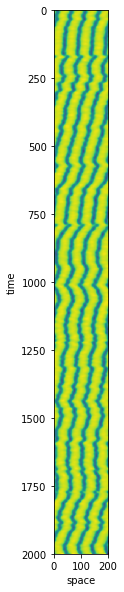

In [4]:
plt.figure(figsize=[10,30])
plt.imshow(A)
plt.xlabel('space')
plt.ylabel('time')

Text(0.5, 1.0, 'Laser Data')

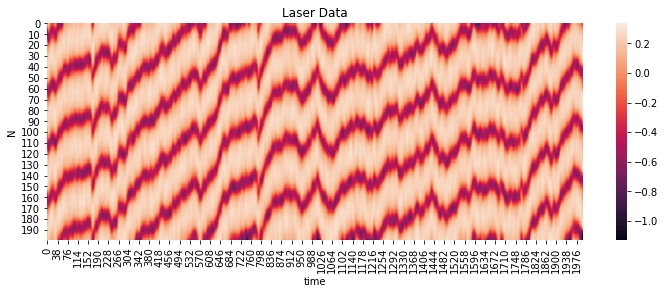

In [14]:
fig, ax = plt.subplots(1, 1, figsize = (12, 4))
sns.heatmap(A.T, ax = ax)
ax.set_xlabel("time")
ax.set_ylabel("N")
ax.set_title("Laser Data")

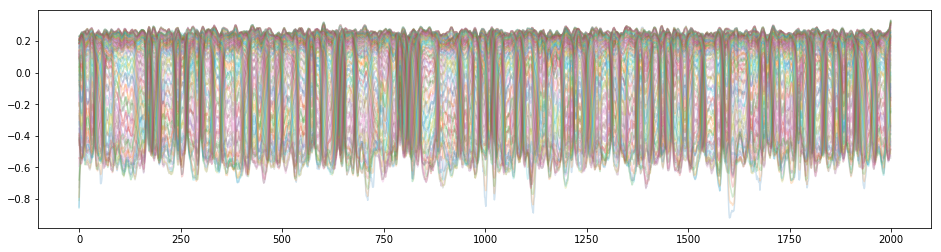

In [4]:
fig, ax = plt.subplots(1,1, figsize = (16,4))
for i in range(100):
    plt.plot(A[:,i], alpha =  0.2)

In [5]:
### 6/27 just playing around investigating



# Helper Functions

In [5]:
def diff(first, second):
    second = set(second)
    return [item for item in first if item not in second]

# validation version
def get_observers(method, 
                  num_observers = 20,
                  missing = 100, 
                  split = 0.2, 
                  observer_range = None,
                  response_range = None,
                  plot_split = True,
                  validation = False,
                  dataset = A):
    """
    arguments:
        method: either random or equal
        missing: either 
            (+) any integer:  (standing for column of the spectogram) or 
            (+) "all" : which stands for all of the remaining target series.
    """
    n_rows = dataset.shape[0]
    n_cols = dataset.shape[1]
    
    train_len = int(n_rows * split)
    if validation != False:
        val_split = int(n_rows * validation)
    else:
        val_split = dataset.shape[0]
    
    test_len =  n_rows - train_len
    col_idx = list(range(n_cols))
    
    #remove the response column which we are trying to use for inpainting
    if method == "random":
        col_idx.remove(missing)
        obs_idx = np.random.choice(col_idx, num_observers, replace = False)
        response  = dataset[ : , missing].reshape(-1,1)
        response_idx = [missing]
        
    elif method == "eq":
        print("equal spacing")
        print("NOT YET IMPLIMENTED")
        
    elif method == "all":
        obs_idx = np.random.choice( col_idx, num_observers, replace = False)
        response_idx  = diff( col_idx, obs_idx.tolist())
        response  = dataset[ : , response_idx]
    
    
    ### The following is problematic because you haven't dealt with the case where they overlap.
    ### BLOCK
    elif method == "block":
        
        ### first consider the response, which has to be LOCKED.
        
        resp_start = response_range[0]
        resp_stop  = response_range[1]
        
        if response_range == None:
            response_idx  = [missing]
            response      = dataset[ : , missing].reshape( -1, 1)
        else:
            response_idx = np.sort( np.array( list( range( resp_start, resp_stop))))
            response     = dataset[ : , response_idx].reshape( -1, len( response_idx))
            
            
        for resp_idx_spec in response_idx:
            col_idx.remove( resp_idx_spec)
        
        if observer_range == None:
            col_idx.remove( missing)
            obs_idx = np.sort( np.random.choice( col_idx, 
                                                num_observers, 
                                                replace = False))
        else:
            obs_start = observer_range[0]
            obs_stop  = observer_range[1]
            obs_idx   = np.sort( np.array( list( range( obs_start, obs_stop))))
            
        # check for problems with the block method:
        union_obs_resp_set = set(obs_idx.tolist()) & set(response_idx.tolist())
        union_obs_resp_lst = list(union_obs_resp_set)
        
        if len(union_obs_resp_lst) != 0:
        
            print("Error: overlap in obs_idx and response_idx: ")
            print("overlap: " + str(union_obs_resp_lst))

            return(1)
            
    if validation == False:
        observers = dataset[ : val_split, obs_idx.tolist()]

        observers_tr = observers[ :train_len, : ]
        observers_te = observers[ train_len : val_split, : ]

        response_tr  = response[   :train_len, : ]
        response_te  = response[   train_len:val_split, : ]
    else:
        val_len = val_split - train_len
        test_len = n_rows - val_split
        
        #train_rows = list(range(train_len))
        #val_rows = list(range(train_len, val_split))
        #test_rows = list(range( val_split, dataset.shape[0]))
        
        observers = dataset[ : , obs_idx.tolist()]

        observers_tr = observers[ :train_len, : ]
        observers_val = observers[ train_len : val_split, : ]
        observers_te = observers[ val_split:, : ]

        response_tr  = response[ : train_len, : ]
        response_val = response[ train_len : val_split, : ]
        response_te  = response[ val_split:, : ]
    
    ### Visualize the train test split, observers and (validation set?)
    if plot_split == True:
        red, yellow, blue, black = [255, 0, 0], [255, 255, 0], [0, 255, 255], [0, 0, 0]
        orange, green, white = [255, 165, 0], [ 0, 128, 0], [255, 255, 255]
        if validation == False:
            #preprocess:
            split_img = np.full(( n_rows, n_cols, 3), black)

            # assign observer lines
            for i in obs_idx:
                split_img[ : , i] = np.full(( 1, n_rows, 3), yellow)

            # assign target area
            for i in response_idx:
                split_img[ :train_len, i] = np.full(( 1, train_len, 3), blue)
                split_img[ train_len:, i] = np.full(( 1, test_len,  3), red)
            legend_elements = [Patch(facecolor='cyan', edgecolor='blue', label='Train'),
                           Patch(facecolor='red', edgecolor='red', label='Test'),
                           Patch(facecolor='yellow', edgecolor='orange', label='Observers')]
        
        else:
            
            #preprocess:
            split_img = np.full(( n_rows, n_cols, 3), black)

            # assign observer lines
            for i in obs_idx:
                split_img[ : , i] = np.full(( 1, n_rows, 3), yellow)

            # assign target area
            for i in response_idx:
                split_img[ :train_len, i] = np.full(( 1, train_len, 3), blue)
                split_img[ train_len:val_split, i] = np.full(( 1, val_len,  3), white)
                split_img[ val_split:, i] = np.full(( 1, test_len,  3), red)
                
            legend_elements = [Patch(facecolor='cyan', edgecolor='blue', label='Train'),
                               Patch(facecolor='white', edgecolor='red', label='Validation'),
                           Patch(facecolor='red', edgecolor='red', label='Test'),
                           Patch(facecolor='yellow', edgecolor='orange', label='Observers')]
        
            
        # Create the figure
        fig, ax = plt.subplots(figsize = ( 6, 6))
        ax.imshow( split_img, aspect = 0.1)
        ax.set_xlabel('space')
        ax.set_ylabel('time')
        
        # The legend:
        #https://matplotlib.org/3.1.1/gallery/text_labels_and_annotations/custom_legends.html
        
        ax.legend(handles=legend_elements, loc='lowerright')
        plt.show()
    
    if validation == False:
        return({"obs_tr"  : observers_tr, 
                "obs_te"  : observers_te,
                "resp_tr" : response_tr,
                "resp_te" : response_te,
                "obs_idx" : obs_idx,
                "resp_idx" : response_idx})
    else:
        return({"obs_tr"  : observers_tr, 
                "obs_val" : observers_val,
                "obs_te"  : observers_te,
                
                "resp_tr" : response_tr,
                "resp_val" : observers_val,
                "resp_te" : response_te,
                
                "obs_idx" : obs_idx,
                "resp_idx" : response_idx})


diff([1,2,3,4,5], [1,2,3])

[4, 5]

# Train Test Split

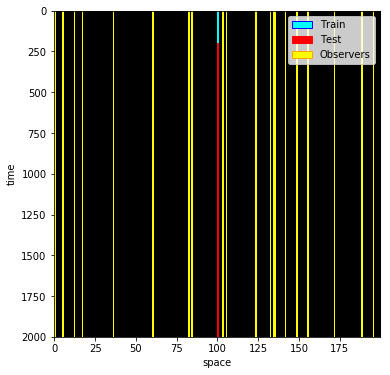

In [6]:
#random example:
dat = get_observers("random",  split = 0.1, missing = 100)

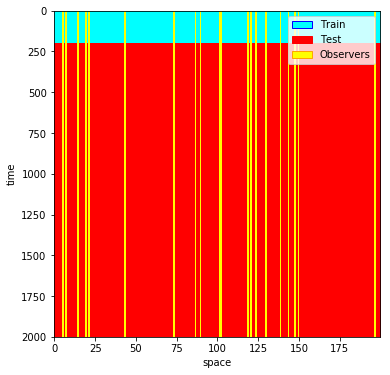

In [7]:
dat= get_observers("all",  split = 0.1)

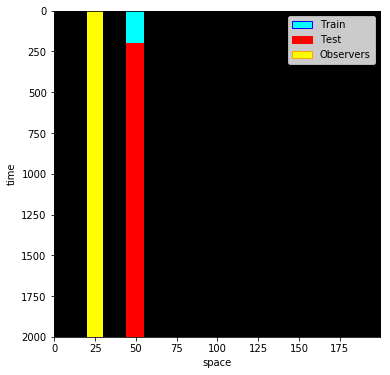

In [8]:
# we notice that there is a problem when the split reduces below around 10%.
### ADD VALIDATION SET???
dat = get_observers("block", response_range = [44, 55], observer_range = [20, 30], split = 0.1)

#add a block on the right and the left
#gaussian importance (an exponential function)

In [9]:
Train  = dat["obs_tr"]
#Val    = dat["obs_val"]
Test   = dat["obs_te"]
xTr    = dat["resp_tr"]
#xVal   = dat["resp_val"]
xTe    = dat["resp_te"]

def print_shape(label, arr):
    print(label + " shape: " + str(arr.shape))
print_shape("Train", Train)
#print_shape("Validation", Val)
print_shape("Test", Test)


print_shape("Test", Test)
#print_shape("xVal", xVal)
print_shape("xTe", xTe)

Train shape: (200, 10)
Test shape: (1800, 10)
Test shape: (1800, 10)
xTe shape: (1800, 11)


In [10]:
Train.shape


(200, 10)

In [11]:
# if you use small training set sizes then you need to use short subsequence lengths.

if (xTr.shape[0] / (xTr.shape[0] + xTe.shape[0])) < 0.2:
    test_subseq_min_len = min(250, int(xTr.shape[0] * 0.3))
else:
    test_subseq_min_len = 250

# Bayesian Optimization (single dimensional output)

Model initialization and exploration run...
Starting optimization... 

Score: 0.1000913
Score: 0.1000913
Score: 0.1000913
Score: 0.058509152
Score: 0.1000913
Score: 0.058509152
Score: 0.058509152
Score: 0.1000913
Score: 0.1000913
Score: 0.058509152
Score: 0.058509152
Score: 0.019025454
Score: 0.019025454
Score: 0.016817218
Score: 0.016817218
Score: 0.020101735
Score: 0.030896837
Score: 0.1000913
Score: 0.1000913
Score: 0.058509152
Score: 0.028496053
Score: 0.019025454
Score: 0.016817218
Score: 0.058509152
Score: 0.04880188
Score: 0.019025454
Score: 0.016817218
Score: 0.019025454
Score: 0.020101735
Score: 0.030896837
Score: 0.019025454
Score: 0.08790404
Score: 0.020101735
Score: 0.019025454
Score: 0.058509152
Score: 0.0858543
Score: 0.016817218
Score: 0.07343739
Score: 0.020101735
Score: 0.016817218
Score: 0.020101735
Score: 0.028496053
Score: 0.030896837
Score: 0.025427207
Score: 0.016642382
Score: 0.04880188
Score: 0.016817218
Score: 0.030896837
Score: 0.019025454
Score: 0.020101735
S

reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Model initialization done. 


Name : GP regression
Objective : 190.62964564945952
Number of Parameters : 7
Number of Optimization Parameters : 7
Updates : True
Parameters:
  GP_regression.           |                value  |  constraints  |       priors      
  Mat52.variance           |   0.9419131431760946  |      +ve      |  iGa(0.001, 0.001)
  Mat52.lengthscale        |                 (5,)  |      +ve      |  iGa(0.001, 0.001)
  Gaussian_noise.variance  |  0.04501078945745273  |      +ve      |  iGa(0.001, 0.001) 

  index  |  GP_regression.Mat52.lengthscale  |  constraints  |       priors      
  [0]    |                       0.06980766  |      +ve      |  iGa(0.001, 0.001)
  [1]    |                       0.38639291  |      +ve      |  iGa(0.001, 0.001)
  [2]    |                       0.08614892  |      +ve      |  iGa(0.001, 0.001)
  [3]    |                       0.07542955  |      +ve      |  iGa(0.001, 0.001)
  [4]    |                       0.06812666  |      +ve      |  

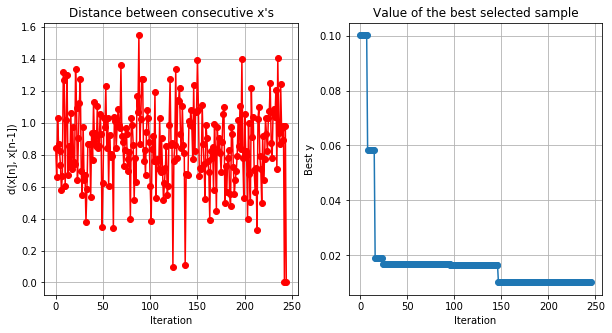

CPU times: user 4min 22s, sys: 1min 22s, total: 5min 45s
Wall time: 33min 19s


In [12]:
%%time

bounds = {
    #'input_scaling': (0, 1),
    #'feedback_scaling': (0, 1),
    'leaking_rate' : (0, 1), 
    'spectral_radius': (0, 1.25),
    'regularization': (-12, 1),
    'connectivity': (-3, 0),
    'n_nodes':  (100, 1000)
}
esn_cv = EchoStateNetworkCV(bounds=bounds,
                            initial_samples=100,
                            subsequence_length=test_subseq_min_len,
                            eps=1e-4,
                            cv_samples=3, 
                            max_iterations=1000, 
                            scoring_method='tanh',
                            verbose=True)

### n_jobs is the number of computer cores.
esn_cv.n_jobs = 8
#esn_cv.n_jobs
best_arguments = esn_cv.optimize(x = Train, y = xTr) 



In [13]:
esn_obs = EchoStateNetwork(**best_arguments)
esn_obs.train(x = Train, y = xTr)

def my_predict(test, n_steps = None):
    if not n_steps:
        n_steps = test.shape[0]
    return esn_obs.predict(n_steps, x = Test[:n_steps,:])

obs_prediction = my_predict(Test)


inputs shape: (11,)
input weights shape: (691, 11)


In [14]:
def plot_timeseries(prediction_, train, test, titl = "ESN ", col2plot = 0):
    train = train[:,col2plot]
    test  = test[:,col2plot]
    trainlen = len(train)
    testlen  = len(test)
    prediction = prediction_[:,col2plot]

    xTrTarg_pd = pd.DataFrame(test)
    t = pd.DataFrame(list(range(len(xTrTarg_pd))))

    Target_pd = pd.concat([xTrTarg_pd, t], axis = 1)

    Target_pd.columns = ["x", "t"]
    #display(Target_pd)
    pred_shape= prediction.reshape(-1,).shape
    resid = test.reshape(-1,)[:pred_shape[0]] - prediction.reshape(-1,)

    fig, ax = plt.subplots(3,1, figsize=(16,10))
    
    rmse_spec =  str(round(myMSE(prediction, test), 5))
    
    #full_dat = np.concatenate([xTr, xTe], axis = 0)
    full_dat = np.concatenate([train, test], axis = 0)
    
    #The first plot
    #sns.lineplot(x = "t", y = "x", data = Target_pd, color = "black", ax = ax[0])
    ax[0].plot(range(full_dat.shape[0]), full_dat,'k', label="Ground Truth",
              color = "blue", linewidth = 3, alpha = 0.4)
    ax[0].plot(range(trainlen,trainlen+testlen),prediction,'k',
             label="prediction", color = "r", linestyle = "--", linewidth = 2, alpha = .95)
    #first plot labels
    ax[0].set_title(titl + "__: Prediction vs Ground Truth, rmse_: " + rmse_spec)
    ax[0].legend(loc=(0.61, 1.1))
    
    # the second plot
    ax[1].plot(range(0,trainlen),np.zeros(trainlen),'k',
             label="", color = "black", alpha = 0.5)
    ax[1].plot(range(trainlen,trainlen+testlen),resid.reshape(-1,),'k',
             label="residual", color = "b", alpha = 0.5)
    # second plot labels
    ax[1].legend(loc=(0.61, 1.1))
    ax[1].set_title(titl + "__: Prediction Residual")
    
    
    
    
    plt.subplots_adjust(hspace=0.5)
    plt.show()
def myMSE(prediction,target):
    return np.sqrt(np.mean((prediction.flatten() - target.flatten() )**2))

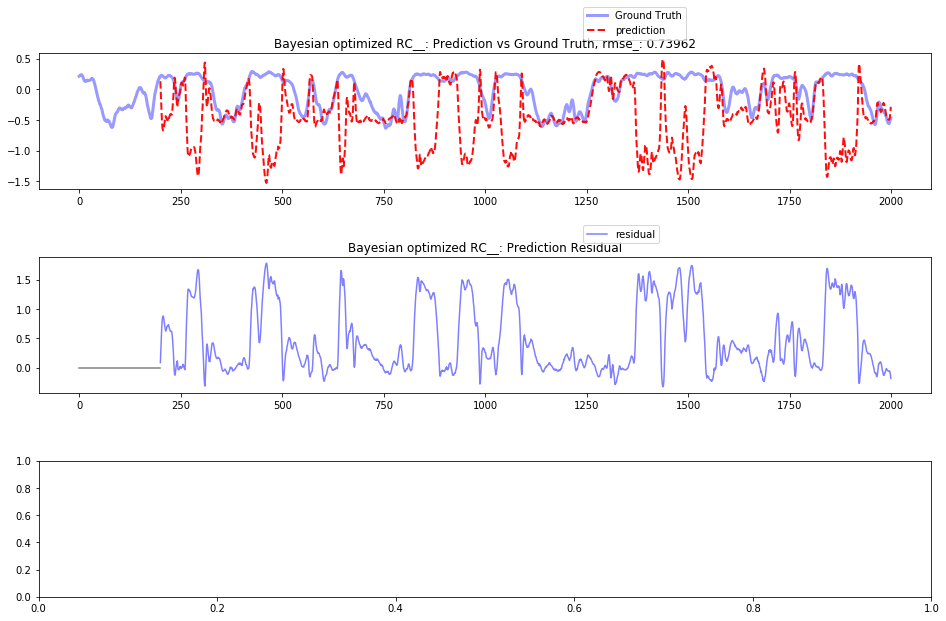

In [15]:
col_to_plot = 3
plot_timeseries(obs_prediction, 
                train = xTr, 
                test = xTe, 
                titl = "Bayesian optimized RC", 
                col2plot = 0) 

# show plot of train and test data


# Interpolation (1 dimensional)

In [16]:
from scipy.interpolate import interp1d
from scipy import interpolate
#f = interp1d(x, y, kind='cubic')

# We want number of observers and performance for the baseline model as well as the rc.

# ip stands for interpolate
ip_resid  = []
ip_pred   = []
ip_actual = []

train_len = xTr.shape[0]

#perform the interpolation laterally:
for row_idx in range(A.shape[0] - train_len):
    row_idx_ = row_idx + train_len
    new_x = np.sort(dat["tr_idx"])
    x = np.arange(200)
    new_y = A[row_idx_, new_x]
    
    # remove 100th item.
    index = 100
    y= A[row_idx,:]

    

    s = interpolate.InterpolatedUnivariateSpline(new_x, new_y)
    y_interpolated = s(x)
    
    predicted_val = y_interpolated[index]
    actual_val = y[index]
    
    ip_pred   += [predicted_val]
    ip_actual += [actual_val]
    ip_resid  += [predicted_val - actual_val] 
    
RC_resid = xTe - obs_prediction
RC_resid = RC_resid.reshape(-1,)

###plots:

fig, ax = plt.subplots(3,1, figsize = (16,18))
ax = ax.flatten()
ax[0].set_title("20 observers: Interpolation 1D vs RC")
sns.lineplot(y = ip_resid, x = np.arange(1600), label = "interpolation residual", ax = ax[1])
sns.lineplot(y = RC_resid, x = np.arange(1600), label = "RC residual", ax = ax[1])

sns.lineplot(y = ip_pred, x = np.arange(1600), label = "interpolation prediction", ax = ax[0], alpha = 0.7)
sns.lineplot(y = obs_prediction.reshape(-1,), x = np.arange(1600), label = "RC prediction", ax = ax[0], alpha = 0.7)
sns.lineplot(y = xTe.reshape(-1,), x = np.arange(1600), label = "Ground truth", ax = ax[0], color = "black")

sns.lineplot(y = np.array(ip_resid)**2, x = np.arange(1600), label = "interpolation MSE", ax = ax[2])
sns.lineplot(y = RC_resid**2, x = np.arange(1600), label = "RC MSE", ax = ax[2])

KeyError: 'tr_idx'

# combining them:

In [ ]:
hi = {}
for x in [5, 10, 20, 40, 100, 180]:
    hi[str(x)] = (str(x))
hi

In [ ]:
%%time
from scipy.interpolate import interp1d
from scipy.interpolate import griddata
ip_resids = {}
ip_preds  = {}
ip_MSEs   = {}

ip2_resids = {}
ip2_preds  = {}
ip2_MSEs   = {}

RC_resids = {}
RC_preds  = {}
RC_MSEs   = {}

for num_observers in [5, 7, 10, 15, 20, 30, 40, 50, 75, 100, 150, 180, 199]: # ]:
    print("processing " + str(num_observers) + " observers")
    dat= get_observers("random", num_observers = num_observers, missing = 60)

    Train  = dat["obs_tr"]
    Test   = dat["obs_te"]
    xTr    = dat["resp_tr"]
    xTe    = dat["resp_te"]

    bounds = {
        #'input_scaling': (0, 1),
        #'feedback_scaling': (0, 1),
        'leaking_rate' : (0, 1), 
        'spectral_radius': (0, 1.25),
        'regularization': (-12, 1),
        'connectivity': (-3, 0),
        'n_nodes':  (100, 1000)
    }
    esn_cv = EchoStateNetworkCV(bounds = bounds,
                                initial_samples=100,
                                subsequence_length=250,
                                eps=1e-4,
                                cv_samples=3, 
                                max_iterations=1000, 
                                scoring_method='tanh',
                                verbose=True)

    ### n_jobs is the number of computer cores.
    esn_cv.n_jobs  = 8
    #esn_cv.verbose = False
    best_arguments = esn_cv.optimize(x = Train, y = xTr ) 
    print("RC completed")
    esn_obs = EchoStateNetwork(**best_arguments)
    esn_obs.train(x = Train, y = xTr)
    obs_prediction = my_predict(Test)
    plt.plot(obs_prediction)
    
    ip_resid  = []
    ip_pred   = []
    ip_actual = []

    train_len = xTr.shape[0]

    #perform the interpolation laterally:
    for row_idx in range(A.shape[0] - train_len):
        row_idx_ = row_idx + train_len
        new_x = np.sort(dat["tr_idx"]) # ***
        x = np.arange(200)
        new_y = A[row_idx_, new_x]

        # remove nth item.
        index = 60
        y= A[row_idx,:]
        
        #1D interpolation
        s = interp1d(new_x, new_y, fill_value = "extrapolate")
        y_interpolated = s(x)

        predicted_val = y_interpolated[index]
        actual_val = y[index]

        ip_pred   += [predicted_val]
        ip_actual += [actual_val]
        ip_resid  += [predicted_val - actual_val] 

        RC_resid = xTe - obs_prediction
        RC_resid = RC_resid.reshape(-1,)
    print("1D completed")
    
    #2D interpolation
    #observer coordinates
    values = []
    point_lst = []
    for i, column_idx in enumerate(dat["tr_idx"]):
            print(column_idx)
            values += list(A[:,column_idx].reshape(-1,))
            point_lst += list(zip(range(A.shape[0]), [column_idx]*A.shape[0]))
    print(len(point_lst))
    print(len(values))
    
    #Training points
    missing_ = 60
    #
    point_lst += list(zip(range(Train.shape[0]) , [missing_]*Train.shape[0]))
    #observer points
    values += list(A[:Train.shape[0], column_idx].reshape(-1,))
    
    points_to_predict = list(zip(list(range(Train.shape[0],A.shape[0])), [missing_]*xTe.shape[0]))
    ip2_pred = griddata(point_lst, values, points_to_predict, method='cubic')
    ip2_resid = ip2_pred.reshape(-1,) - xTe.reshape(-1,)
    ip2_resid = ip2_resid.reshape(-1,)
    #points we can see in the training set

    ###plots:
    print(str(num_observers))
    ip_resids[str(num_observers) + " obs"] = ip_resid
    ip_preds[ str(num_observers) + " obs"] = ip_pred
    ip_MSEs[ num_observers]  = np.sum(np.array(ip_resid)**2)
    
    ip2_resids[str(num_observers) + " obs"] = ip2_resid
    ip2_preds[ str(num_observers) + " obs"] = ip2_pred
    ip2_MSEs[ num_observers]  = np.sum(np.array(ip2_resid)**2)
    
    
    RC_resids[str(num_observers) + " obs"] = RC_resid
    RC_preds[ str(num_observers) + " obs"] = obs_prediction
    RC_MSEs[ num_observers]  = np.sum(RC_resid**2)
    

In [ ]:
#lets calculate the loss!
fig, ax = plt.subplots(1,1, figsize = (14,6))
rc = pd.DataFrame(RC_MSEs, index = ["RC"])
ip = pd.DataFrame(ip_MSEs, index = ["IP_1D"])
ip2 = pd.DataFrame(ip2_MSEs, index = ["IP_2D"])
MSE_pd = pd.concat([rc,  ip2], axis = 0).T #, ip

sns.lineplot(data = np.log(MSE_pd))
ax.set_title("Interpolation vs RC: Log(MSE) vs number of observers ")
ax.set_xlabel("Number of Observers")
ax.set_ylabel("Log( MSE)")

plt.subplots_adjust(hspace = 0.3)

In [ ]:
fig, ax = plt.subplots(3,1, figsize = (16,12))
ax = ax.flatten()
sns.lineplot(y=xTe.reshape(-1,), x= range(xTe.shape[0]), label = "ground truth", color = "black", ax = ax[0])
sns.lineplot(y=ip2_preds["20 obs"].reshape(-1,), x= range(xTe.shape[0]), label = "2d interpolation", alpha = 0.8, linestyle = "--", ax = ax[0])
sns.lineplot(y=obs_prediction.reshape(-1,), x= range(xTe.shape[0]), label = "rc", alpha = 0.5, ax = ax[0])
ax[0].set_title = "test set"
#np.sum((xTe.reshape(-1) - ip2_preds["20 obs"])**2)

#sns.lineplot(y=ip2_resids["20 obs"].reshape(-1,), x = range(ip2_resids["20 obs"].shape[0]), label = "2d interpolation", alpha = 0.8, linestyle = "--", ax = ax[1])
#sns.lineplot(y=RC_resids.reshape(-1,), x= range(xTe.shape[0]), label = "rc", alpha = 0.5, ax = ax[1])
#ax[0].set_title = "test set"
RC_loss = RC_resid.reshape(-1,)**2
ip_loss = (ip2_pred - xTe.reshape(-1,))**2

sns.lineplot(y=RC_resid.reshape(-1,)**2, x = range(ip2_preds["20 obs"].shape[0]), label = "RC", alpha = 0.5, linestyle = "--", ax = ax[1])
sns.lineplot(y=(ip2_pred - xTe.reshape(-1,))**2, x = range(ip2_preds["20 obs"].shape[0]), label = "2d interpolation", alpha = 0.5, linestyle = "--", ax = ax[1])

sns.lineplot(y=RC_loss - ip_loss, x = range(ip2_preds["20 obs"].shape[0]), label = "2d interpolation", alpha = 0.8, linestyle = "--", ax = ax[2])

# Now we want to see the 2D interpolation:

In [ ]:
x = np.arange(200)
y = A[row,dat["tr_idx"]+[index]]

# remove 100th item.
index = 100
new_x = np.delete(x, index)
new_y = np.delete(y, index)

from scipy import interpolate

s = interpolate.InterpolatedUnivariateSpline(new_x, new_y)
y_interpolated = s(x)

predicted_val = y_interpolated[index]
actual_val = y[index]

ip_pred   += [predicted_val]
ip_actual += [actual_val]
ip_resid  += [predicted_val - actual_val] 

In [ ]:
plt.plot(x, y, linewidth = 5, linestyle = "--")
plt.plot(x, y_interpolated)

# Now testing multiple outputs:

In [ ]:
%%time

dat = get_observers("all")
#plt.plot(xTr)
Train  = dat["obs_tr"]
Test   = dat["obs_te"]
xTr    = dat["resp_tr"]
xTe    = dat["resp_te"]

In [ ]:
%%time

bounds = {
    #'input_scaling': (0, 1),
    #'feedback_scaling': (0, 1),
    'leaking_rate' : (0, 1), 
    'spectral_radius': (0.01, 1.25),
    'regularization': (-12, 1),
    'connectivity': (-3, 0),
    'n_nodes':  (100, 1000)
}
esn_cv = EchoStateNetworkCV(bounds=bounds,
                            initial_samples=100,
                            subsequence_length=250,
                            eps=1e-4,
                            cv_samples=3, 
                            max_iterations=1000, 
                            scoring_method='tanh',
                            verbose=True)

### n_jobs is the number of computer cores.
esn_cv.n_jobs = 8
esn_cv.n_jobs
best_arguments = esn_cv.optimize(x = Train, y = xTr) 

In [ ]:
esn_obs = EchoStateNetwork(**best_arguments)
esn_obs.train(x = Train, y = xTr)
BO_obs_prediction = my_predict(Test)
#plot_timeseries(prediction, train = xTrTarg, test = xTeTarg )

plot_timeseries(BO_obs_prediction, train = xTr, test = xTe, titl = "Bayes", col2plot = 0)
plot_timeseries(BO_obs_prediction, train = xTr, test = xTe, titl = "Bayes", col2plot = 40)


In [ ]:
BO_obs_prediction.shape

In [ ]:
np.abs(xTe[:,i]-BO_obs_prediction[:,i])

In [ ]:
fig, ax = plt.subplots(1,1,figsize = (16,4))
for i in range(len(dat["te_idx"])):
    resid_i = np.abs(xTe[:,i]-BO_obs_prediction[:,i])
    plt.plot( resid_i, alpha = 0.01, color = "blue")
ax.set_title = "Absolute Residual: all 180 Timeseries"

In [ ]:
fig, ax = plt.subplots(1,1,figsize = (16,4))
for i in range(len(dat["te_idx"])):
    resid_i = (xTe[:,i]-BO_obs_prediction[:,i])**2
    plt.scatter(x = range(len(resid_i)), y = resid_i, alpha = 0.01, c= resid_i)
ax.set_title = "Absolute Residual: all 180 Timeseries"

In [ ]:
loss_np = np.zeros([xTe.shape[0], xTr.shape[1]])
total_np = np.zeros([A.shape[0], A.shape[1]])
fig, ax = plt.subplots(1,1,figsize = (16,4))
for count, i in enumerate(range(len(dat["te_idx"]))):
    resid_i = abs(xTe[:,i] - BO_obs_prediction[:,i])#**2
    loss_np[:,i] = resid_i
    total_np[400:,i] = BO_obs_prediction[:,i]
    
    plt.plot( resid_i, alpha = 0.04, color = "blue")
for count, i in enumerate(range(len(dat["tr_idx"]))):
    resid_i = (xTe[:,i] - BO_obs_prediction[:,i])**2
    #print(resid_i.shape)
    total_np[400:,i] = BO_obs_prediction[:,i]
    #
    
ax.set_title = "Absolute Residual: all 180 Timeseries"

In [ ]:
fig, ax = plt.subplots(1,2, figsize=[10,8])
ax = ax.flatten()
#plt.imshow(loss_np)
sns.heatmap(loss_np, ax = ax[0])
ax[0].set_title("residual error")

ax[1].set_title("prediction")
sns.heatmap(total_np, ax = ax[1])

In [ ]:
plt.imshow(total_np)

In [ ]:
best_arguments

# Here goes the redo attempt
